In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import itertools # confusion matrix

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
drug_data = pd.read_csv("drugsCom_raw (1).tsv",sep='\t')
drug_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
drug_data['date']=pd.to_datetime(drug_data.date)
drug_data['rating']=drug_data['rating'].astype('int')
drug_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [4]:
drug_data.dtypes

Unnamed: 0              int64
drugName               object
condition              object
review                 object
rating                  int32
date           datetime64[ns]
usefulCount             int64
dtype: object

In [5]:
drug_data.condition.value_counts()

Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: condition, Length: 884, dtype: int64

### In the dataset we can see many patients conditions but we have to focus only the below conditions 
### 1) Depression   2)High Blood Pressure  3)Diabetes ,type2

In [6]:
df = drug_data.loc[(drug_data['condition'] == 'High Blood Pressure') | (drug_data['condition'] == 'Diabetes, Type 2') | (drug_data['condition'] == 'Depression')]
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,2017-03-09,54
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,2011-05-07,3
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,2016-04-27,3
50,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,2017-10-24,24
67,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,2013-06-20,166


In [7]:
df.shape

(13944, 7)

In [8]:
df.isnull().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [9]:
df.condition.value_counts()

Depression             9069
Diabetes, Type 2       2554
High Blood Pressure    2321
Name: condition, dtype: int64

The data seems to be queit imbalanced as Depression is of high frequency as compared to the other two.

In [10]:
df.duplicated().sum()

0

In [11]:
df.duplicated(subset=['drugName','condition','review','date']).sum()

1

In [12]:
df[df.duplicated(subset=['drugName','condition','review'])]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
143051,45483,Fluoxetine,Depression,"""I have suffered from severe depression/anxiet...",9,2015-04-28,16


In [13]:
df.loc[(drug_data['condition'] == 'Depression') & (drug_data['drugName'] == 'Fluoxetine')  & (drug_data['date'] == '2015-04-28')]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
51333,45484,Fluoxetine,Depression,"""I have suffered from severe depression/anxiet...",9,2015-04-28,91
143051,45483,Fluoxetine,Depression,"""I have suffered from severe depression/anxiet...",9,2015-04-28,16


In [14]:
df.value_counts(["drugName", "condition"])

drugName          condition          
Bupropion         Depression             549
Sertraline        Depression             459
Venlafaxine       Depression             437
Pristiq           Depression             418
Desvenlafaxine    Depression             414
                                        ... 
Corzide 80 / 5    High Blood Pressure      1
Corgard           High Blood Pressure      1
Insulin isophane  Diabetes, Type 2         1
Acarbose          Diabetes, Type 2         1
Nitro-Dur         High Blood Pressure      1
Length: 334, dtype: int64

In [15]:
df['condition'].value_counts()

Depression             9069
Diabetes, Type 2       2554
High Blood Pressure    2321
Name: condition, dtype: int64

<AxesSubplot:xlabel='count', ylabel='condition'>

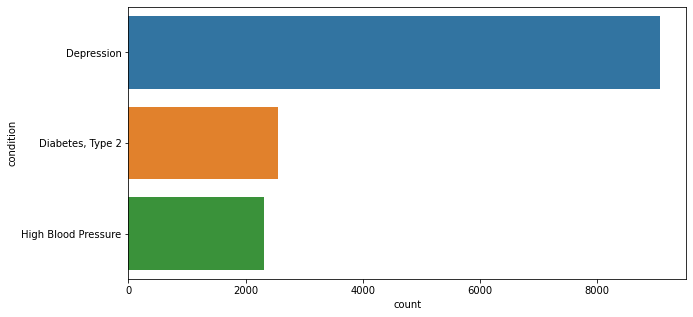

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(y = 'condition',data = df,order=pd.value_counts(df['condition']).iloc[:10].index)

Text(0.5, 1.0, 'Top 20 Most popular drugs based on counts')

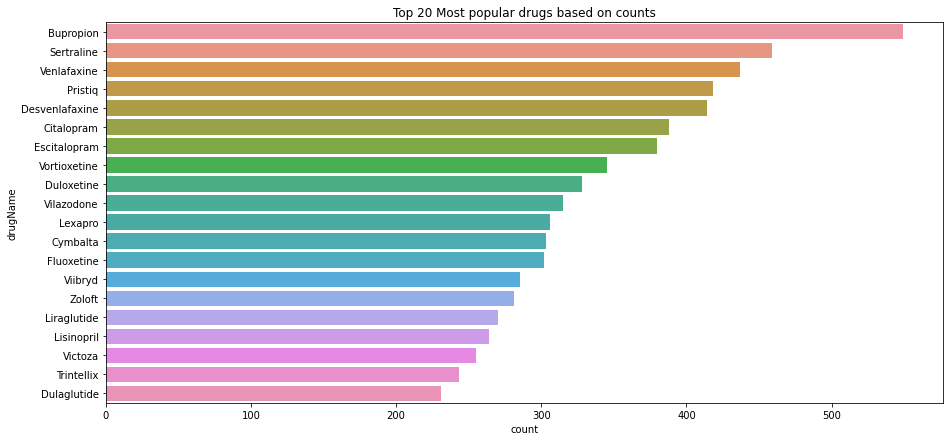

In [17]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'drugName',data = df,order=pd.value_counts(df['drugName']).iloc[:20].index)
plt.title('Top 20 Most popular drugs based on counts')


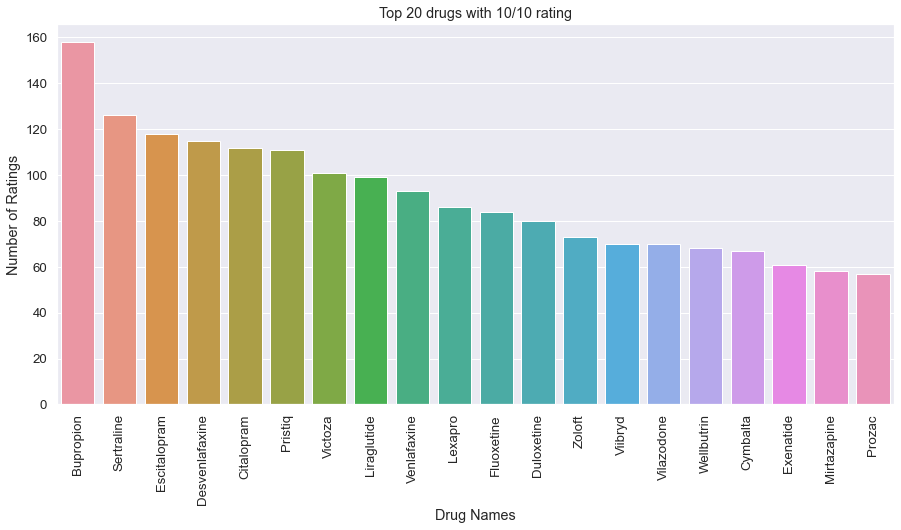

In [18]:
# This barplot shows the top 20 drugs with the 10/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 7]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

This is a bar graph which shows the top 20 drugs given in the data set with a rating of 10/10. 'Bupropine' is the drug with the highest number of 10/10 ratings, almost 160 Ratings in the data set for 'Bupropine'.

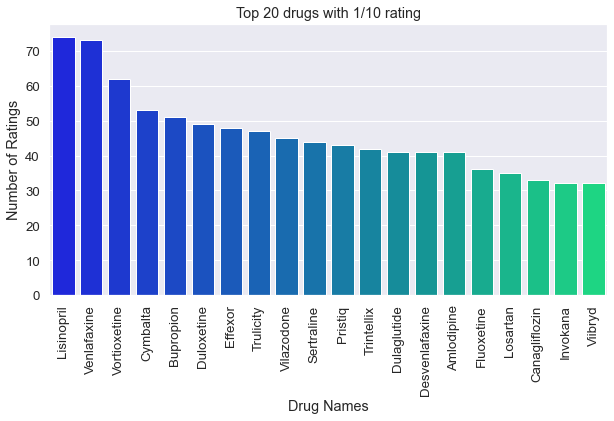

In [19]:
# This barplot shows the Top 20 drugs with the 1/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 5]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);


This is a bar graph that shows the top 20 drugs given in the data set with a rating of 1/10. 'Lisinopril' is the drug with the highest number of 1/10 ratings, about 75.

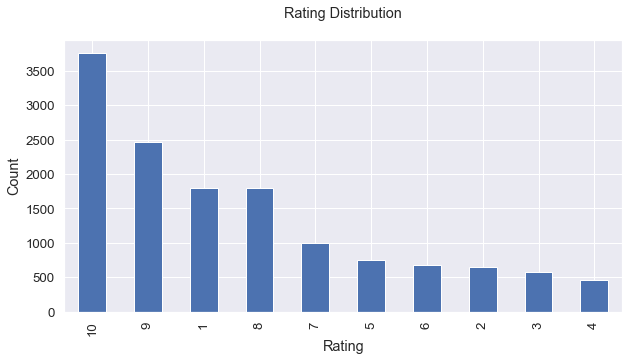

In [20]:
plt.rc("font", size=15)
df['rating'].value_counts(sort=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

This shows the distribution of the ratings from 1 to 10 in the data set.

<Figure size 1296x360 with 0 Axes>

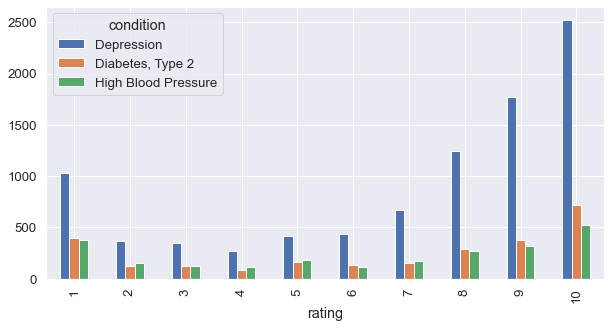

In [21]:
# bar plot between 2 different categories 
plt.figure(figsize=(18,5))
pd.crosstab(df['rating'], df['condition']).plot(kind="bar")
plt.show()

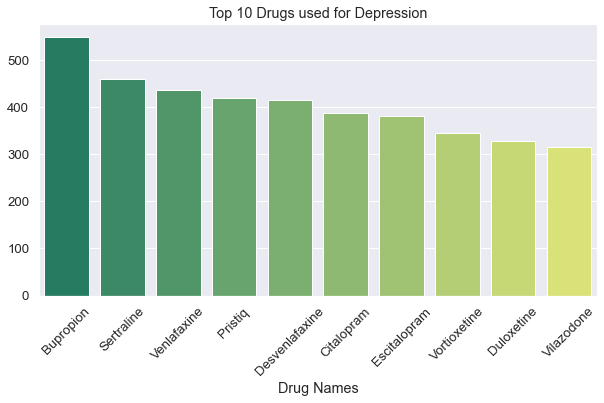

In [22]:
# Top 10 drugs which are used for the top condition, that is Depression
df1 = df[df['condition'] == 'Depression']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Depression")
plt.setp(sns_.get_xticklabels(), rotation = 45);

This is a bar graph which exhibits the top 10 drug names for the people suffering from Depression. In this data set 'Bupropion' is the most prominent drug.

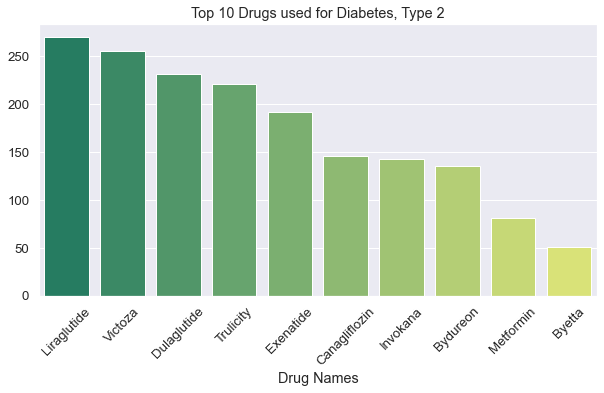

In [23]:
# Top 10 drugs which are used for the top condition, that is Depression
df1 = df[df['condition'] == 'Diabetes, Type 2']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Diabetes, Type 2")
plt.setp(sns_.get_xticklabels(), rotation = 45);

This is a bar graph which exhibits the top 10 drug names for the people suffering from Diabetes, Type 2. In this data set 'Liraglutide' is the most prominent drug.

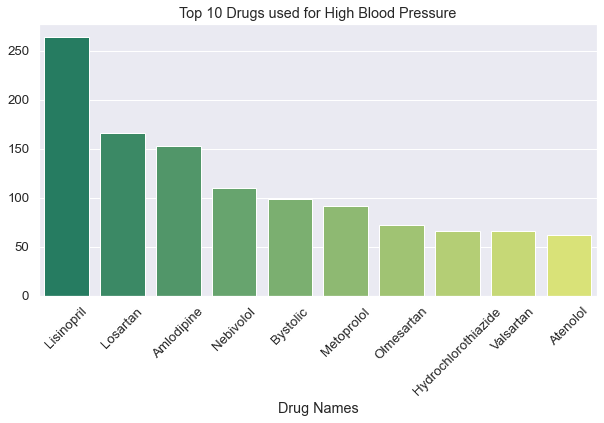

In [24]:
# Top 10 drugs which are used for the top condition, that is Depression
df1 = df[df['condition'] == 'High Blood Pressure']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for High Blood Pressure")
plt.setp(sns_.get_xticklabels(), rotation = 45);

This is a bar graph which exhibits the top 10 drug names for the people suffering from High Blood Pressure. In this data set 'Lisinopril' is the most prominent drug.

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


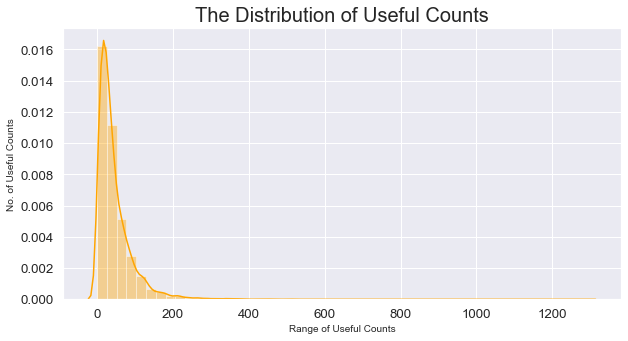

In [25]:
# plotting a dist plot

plt.rcParams['figure.figsize'] = (10, 5)
sns.distplot(df['usefulCount'], color = 'orange')
plt.title('The Distribution of Useful Counts', fontsize = 20)
plt.xlabel('Range of Useful Counts', fontsize = 10)
plt.ylabel('No. of Useful Counts', fontsize = 10)
plt.show()

In [26]:
df.to_csv('dataset.csv')

In [27]:
df1 = df.drop(['drugName','rating','date','usefulCount','Unnamed: 0'], axis=1)
df1.head()

,condition,review
11,Depression,"""I have taken anti-depressants for years, with..."
31,Depression,"""1 week on Zoloft for anxiety and mood swings...."
44,Depression,"""my gp started me on Venlafaxine yesterday to ..."
50,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l..."
67,Depression,"""This medicine saved my life. I was at my wits..."


In [28]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS

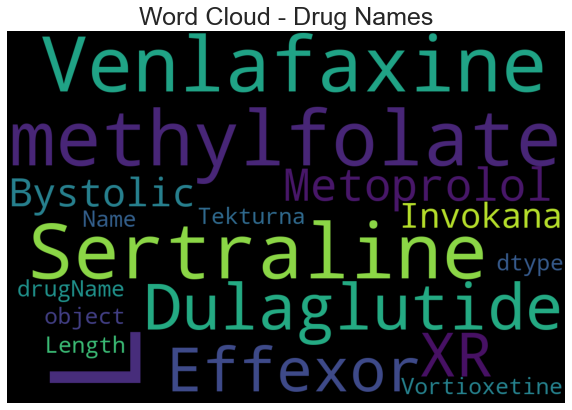

In [29]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords, width = 1200, height = 800).generate(str(df['drugName']))

plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Word Cloud - Drug Names', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [30]:
# segregating dataframe for analyzing individual condition
df1_dep = df1[(df1['condition']=='Depression')]
df1_bp = df1[(df1['condition']=='High Blood Pressure')]
df1_diab = df1[(df1['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word Cloud for Depression')

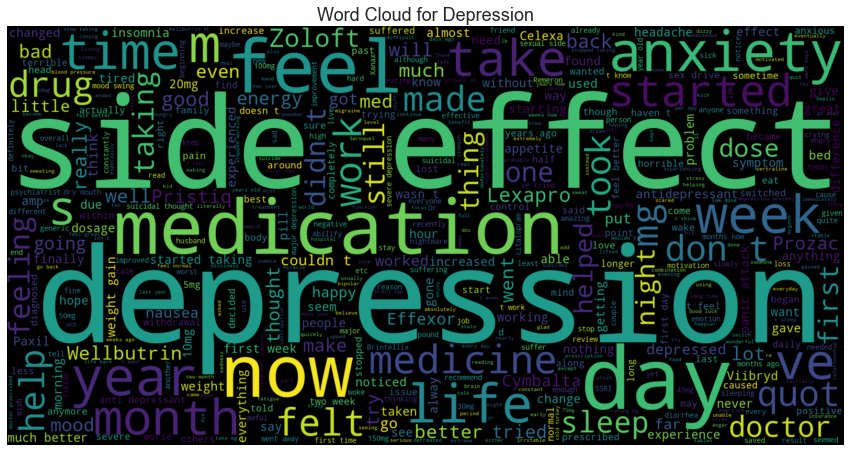

In [31]:
wc1 = WordCloud(max_words=500, stopwords = stopwords, width=1600, height=800).generate(" ".join(df1_dep.review))
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.imshow(wc1, interpolation='bilinear')
plt.title('Word Cloud for Depression', fontsize=18)

Text(0.5, 1.0, 'Word Cloud for High blood pressure')

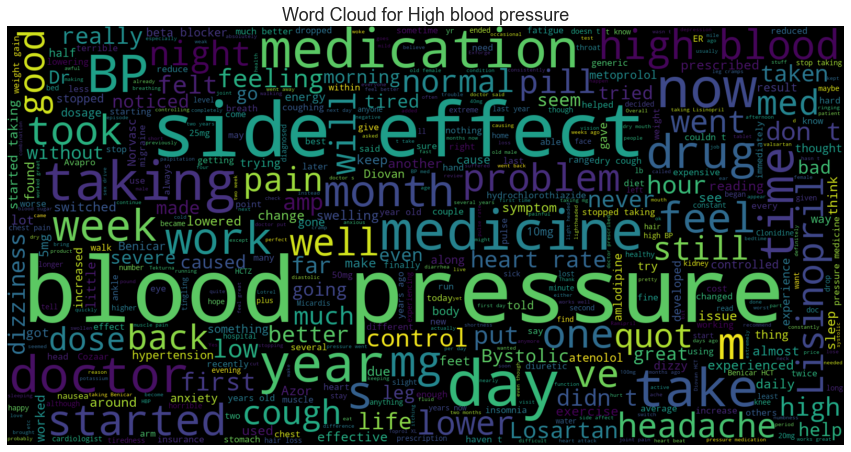

In [32]:
wc1 = WordCloud(max_words=500, stopwords = stopwords, width=1600, height=800).generate(" ".join(df1_bp.review))
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.imshow(wc1, interpolation='bilinear')
plt.title('Word Cloud for High blood pressure', fontsize=18)

Text(0.5, 1.0, 'Word Cloud for Diabaties, Type 2')

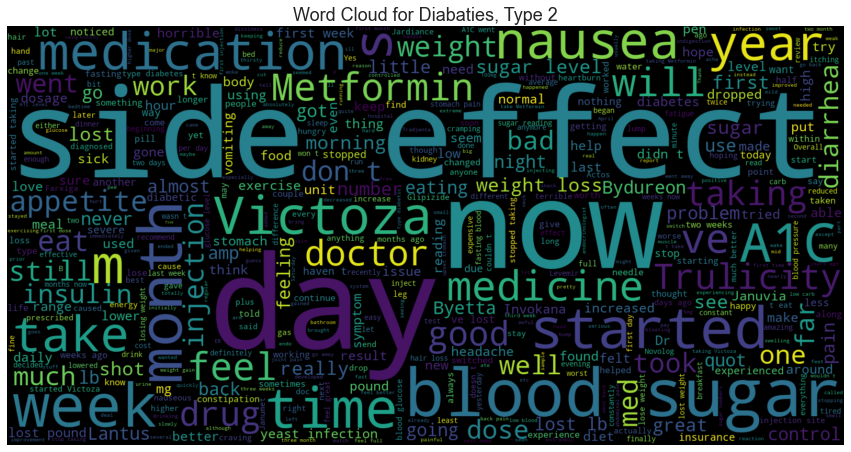

In [33]:
wc3 = WordCloud(max_words=500, stopwords = stopwords, width=1600, height=800).generate(" ".join(df1_diab.review))
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.imshow(wc3, interpolation='bilinear')
plt.title('Word Cloud for Diabaties, Type 2', fontsize=18)

In [34]:
# To set the width of the column to maximum
pd.set_option('max_colwidth', -1)

C:\Users\ankit\AppData\Local\Temp\ipykernel_12964\999061969.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [35]:
df1.head()

,condition,review
11,Depression,"""I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."""
31,Depression,"""1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one but that subsided as the week went on. I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed."""
44,Depression,"""my gp started me on Venlafaxine yesterday to help with depression and the change,a hour after taking them i was feeling very sick couldn,t stomach food or fluids, thought keep it up as she told me they did come with some side effects which would get better,took another one last night and was so ill i couldn,t stand ,being sick sweating shaking thought i was going to pass out. Did get some sleep hopeing to feel better this morning,took another one and felt so spaced out dry mouth shaking ,sick, so booked in to see gp again to make sure i should be feeling like this, only to find out she had put me on the wrong dose should have been on 37.5mg was put on 150mg, now on right dose hope this will be better"""
50,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my last post as I wanted to give it a few months to see how this was going to work. So, I have been on Trulicity for six months now with Metformin. When I hit the five month period the diarrhea, gas, sulphur belching finally subsided. I now longer have any of those side effects. However, I still haven&#039;t lost any weight at all, but I think that was because when I first started Trulicity I was taking it with Glimepiride and that one has a side effect of weight gain so I think the two meds were fighting each other lol. I have been back on the Metformin with Trulicity for about a week now, so we will see what this does. I was diagnosed as stage 3 chronic kidney disease (CKD 3) so I am watching diet closely."""
67,Depression,"""This medicine saved my life. I was at my wits end with anti-depressants and was ready to give up. My doctor finally prescribed me this after many failed medications, I am so glad she did. I honestly do not know where I would be without Effexor XR. Side effects were very mild compared to other anti-depressants I tried. I was drowsy for the first couple days, but it was tolerable. I highly recommend this for severe depression. I would also like to mention for people to realize there is light at the end of the tunnel and YOU WILL GET BETTER, and to never give up."""


In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [39]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
from bs4 import BeautifulSoup
import re


In [41]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop_words]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [42]:
df1['review_clean'] = df1['review'].apply(review_to_words)
df1.head()

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,condition,review,review_clean
11,Depression,"""I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.""",taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect
31,Depression,"""1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one but that subsided as the week went on. I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed.""",week zoloft anxiety mood swing take mg morning breakfast nausea day one subsided week went get jitter hr taking followed yawning feel much better though le angry stressed
44,Depression,"""my gp started me on Venlafaxine yesterday to help with depression and the change,a hour after taking them i was feeling very sick couldn,t stomach food or fluids, thought keep it up as she told me they did come with some side effects which would get better,took another one last night and was so ill i couldn,t stand ,being sick sweating shaking thought i was going to pass out. Did get some sleep hopeing to feel better this morning,took another one and felt so spaced out dry mouth shaking ,sick, so booked in to see gp again to make sure i should be feeling like this, only to find out she had put me on the wrong dose should have been on 37.5mg was put on 150mg, now on right dose hope this will be better""",gp started venlafaxine yesterday help depression change hour taking feeling sick stomach food fluid thought keep told come side effect would get better took another one last night ill stand sick sweating shaking thought going pas get sleep hopeing feel better morning took another one felt spaced dry mouth shaking sick booked see gp make sure feeling like find put wrong dose mg put mg right dose hope better
50,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my last post as I wanted to give it a few months to see how this was going to work. So, I have been on Trulicity for six months now with Metformin. When I hit the five month period the diarrhea, gas, sulphur belching finally subsided. I now longer have any of those side effects. However, I still haven&#039;t lost any weight at all, but I think that was because when I first started Trulicity I was taking it with Glimepiride and that one has a side effect of weight gain so I think the two meds were fighting each other lol. I have been back on the Metformin with Trulicity for about a week now, so we will see what this does. I was diagnosed as stage 3 chronic kidney disease (CKD 3) so I am watching diet closely.""",hey guy month since last post wanted give month see going work trulicity six month metformin hit five month period diarrhea gas sulphur belching finally subsided longer side effect however still lost weight think first started trulicity taking glimepiride one side effect weight gain think two med fighting lol back metformin trulicity week see diagnosed stage chronic kidney disease ckd watching diet closely
67,Depression,"""This medicine saved my life. I was at my wits end with anti-depressants and was ready to give up. My doctor finally prescribed me this after many failed medications, I am so glad she did. I honestly do not know where I would be without Effexor XR. Side effects were very mild compared to other anti-depressants I tried. I was drowsy for the first couple days, but it was tolerab

In [43]:
def preprocess(text):
    words= word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    final_string = " ".join(filtered_words)
    return final_string
df1['review_clean'] = df1['review_clean'].apply(preprocess)

In [44]:
def sentiment(review):
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

df1['sentiment'] = sentiment(df1['review'])
df1['sentiment_proessed'] = sentiment(df1['review_clean'])

In [45]:
np.corrcoef(df1['sentiment'],df['rating'])

array([[1.        , 0.38708344],
       [0.38708344, 1.        ]])

In [46]:
np.corrcoef(df1['sentiment_proessed'],df['rating'])

array([[1.        , 0.37740536],
       [0.37740536, 1.        ]])

As we can see, there is no much difference in correlation coefficent between rating-reivew and rating - clean_review, seems like we have not lost more of the important data

In [47]:
df1['review'].iloc[0]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [48]:
df1['review_clean'].iloc[0]

'taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect'

In [49]:
#Creating features and Target Variable
X_feat=df1['review_clean']
y=df1['condition']


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
#Bag of Words
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)
count_train

<11155x11173 sparse matrix of type '<class 'numpy.int64'>'
	with 329269 stored elements in Compressed Sparse Row format>

accuracy:   0.955
Confusion matrix, without normalization


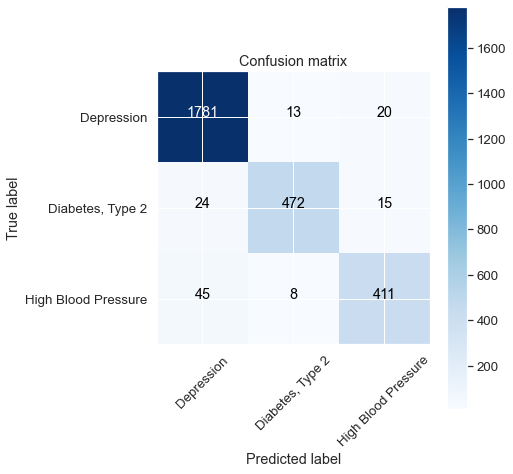

In [53]:
#Machine Learning Model : Naive Bayes
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
plt.rcParams['figure.figsize'] = [7, 7]

cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.951
Confusion matrix, without normalization


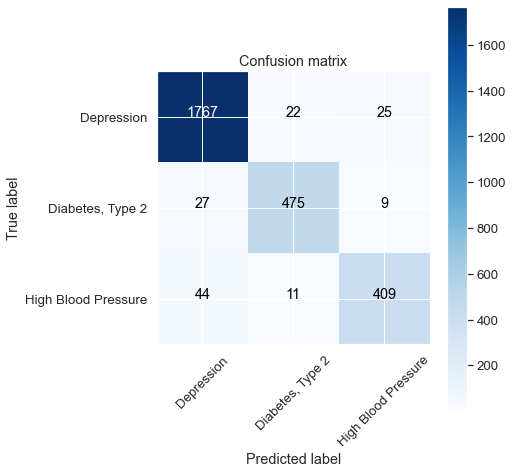

In [54]:
#Machine Learning Model : Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

In [55]:
#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

accuracy:   0.896
Confusion matrix, without normalization


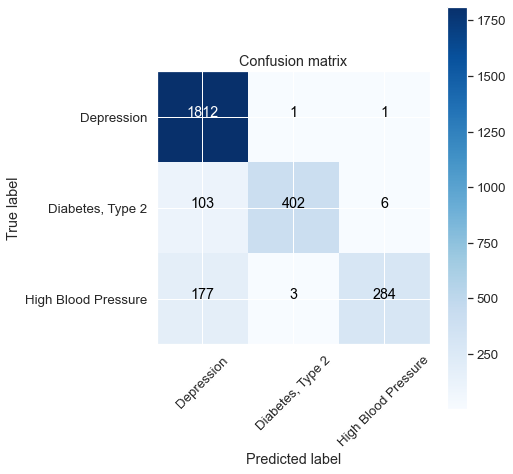

In [56]:
#Machine Learning Model : Naive Bayes
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.961
Confusion matrix, without normalization


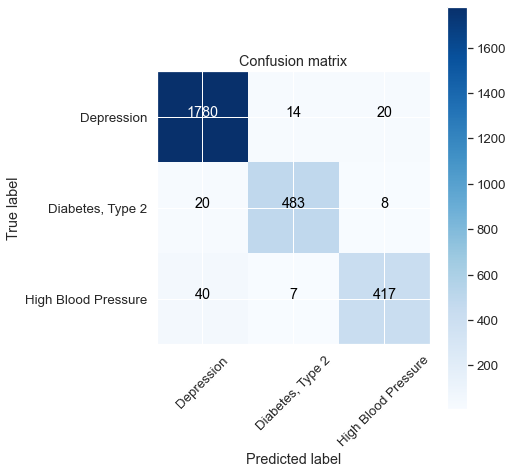

In [57]:
#Machine Learning Model TFIDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.965
Confusion matrix, without normalization


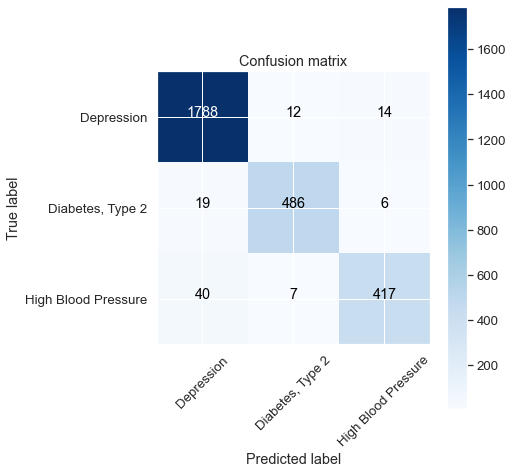

In [58]:
#TFIDF: Bigrams
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.968
Confusion matrix, without normalization


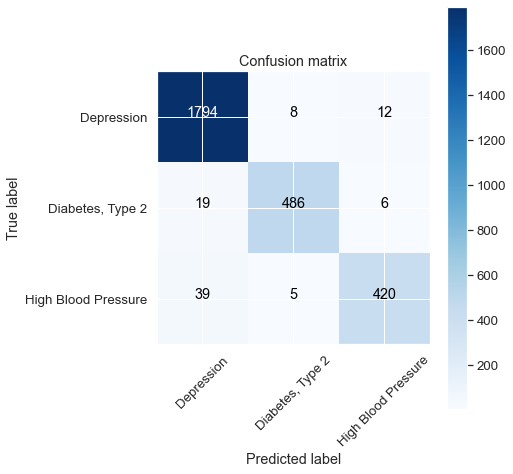

In [59]:
#TFIDF : Trigrams
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

In [60]:
#Most important Features
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = tfidf_vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Depression obsessed 0.5912296443763785
Depression fantastical 0.636313621849543
Depression grape 0.6614069802864979
Depression nuclear 0.7501222884829288
Depression onlgyza 0.7621871172168244
Depression spilling 0.7837503984379536
Depression amphetamine 0.8193633686984297
Depression viva 1.348125598128728
Depression woe 1.4226843718898363
Depression acquired 2.3567487141458954
High Blood Pressure suspect 0.6472018637423268
High Blood Pressure consulting 0.6536989617259523
High Blood Pressure syrup 0.6676087433375685
High Blood Pressure susceptible 0.6790558279190647
High Blood Pressure externally 0.7248491759419768
High Blood Pressure debilitatingly 0.7394408423573117
High Blood Pressure surrounding 0.839881082751912
High Blood Pressure defeating 0.9100324636603008
High Blood Pressure latunda 0.9872310805335693
High Blood Pressure unimportant 3.394228983074827
Diabetes, Type 2 spf 0.5911240630017233
Diabetes, Type 2 tender 0.6425683571080893
Diabetes, Type 2 deteriorating 0.66151543229

c:\users\ankit\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression obsessed 0.5912296443763785
Depression fantastical 0.636313621849543
Depression grape 0.6614069802864979
Depression nuclear 0.7501222884829288
Depression onlgyza 0.7621871172168244
Depression spilling 0.7837503984379536
Depression amphetamine 0.8193633686984297
Depression viva 1.348125598128728
Depression woe 1.4226843718898363
Depression acquired 2.3567487141458954


In [62]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure suspect 0.6472018637423268
High Blood Pressure consulting 0.6536989617259523
High Blood Pressure syrup 0.6676087433375685
High Blood Pressure susceptible 0.6790558279190647
High Blood Pressure externally 0.7248491759419768
High Blood Pressure debilitatingly 0.7394408423573117
High Blood Pressure surrounding 0.839881082751912
High Blood Pressure defeating 0.9100324636603008
High Blood Pressure latunda 0.9872310805335693
High Blood Pressure unimportant 3.394228983074827


In [63]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 spf 0.5911240630017233
Diabetes, Type 2 tender 0.6425683571080893
Diabetes, Type 2 deteriorating 0.6615154322988898
Diabetes, Type 2 accomplishment 0.6871418522724255
Diabetes, Type 2 tenderness 0.6924253579313517
Diabetes, Type 2 acceptable 0.6975431376062511
Diabetes, Type 2 driver 0.7587084837605973
Diabetes, Type 2 temp 1.4951806402711596
Diabetes, Type 2 mindful 2.0423013522689497
Diabetes, Type 2 downward 2.645767734500877


In [64]:
## Function for Extracting Top drugs

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst


In [65]:
def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test


In [66]:
sentences = [
  "I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
    "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me",
    
  ]


In [67]:
tfidf_trigram = tfidf_vectorizer3.transform(sentences)


predictions = pass_tf.predict(tfidf_trigram)


In [68]:
for text, label in zip(sentences, predictions):
    if label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()


text: I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. 
Condition: High Blood Pressure
Top 3 Suggested Drugs:
Losartan
Aldactone
Spironolactone

text: This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap. 
Condition: Depression
Top 3 Suggested Drugs:
Sertraline
Zoloft
Viibryd

text: I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losi

In [69]:
df_testsent = predict_text(sentences)
df_testsent


,test_sent,prediction
0,tekturna day effect immediate also calcium channel blocker tiazac hydrochlorothiazide put tekturna palpitation experienced diovan ugly drug opinion company produce however palpitation pretty bad diovan hour monitor ekg etc day substituting tekturna diovan palpitation,High Blood Pressure
1,third med tried anxiety mild depression week hate much dizzy major diarrhea feel worse started contacting doc changing asap,Depression
2,got diagnosed type doctor prescribed invokana metformin beginning sugar went normal second week losing much weight side effect yet miracle medicine,"Diabetes, Type 2"


In [70]:
import joblib
joblib.dump(tfidf_vectorizer3, 'tfidfvectorizer.pkl')
joblib.dump(pass_tf, 'passmodel.pkl')

['passmodel.pkl']

vectorizer = joblib.load('tfidfvectorizer.pkl')
model = joblib.load('passmodel.pkl')

test = model.predict(vectorizer.transform(["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations"]))
test[0]


'High Blood Pressure'